In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [10]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
last_year

datetime.date(2016, 8, 23)

In [11]:
# Perform a query to retrieve the data and precipitation scores
results = session.query( Measurement.date, Measurement.prcp).\
filter(Measurement.date > '2016-08-23').all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(results, columns = [ 'date', 'Precipitation'])
precip.tail()

,date,Precipitation
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50
2222,2017-08-23,0.45


In [13]:
# Sort the dataframe by date
date_sort = precip.groupby(['date']).sum()
date_sort

,Precipitation
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


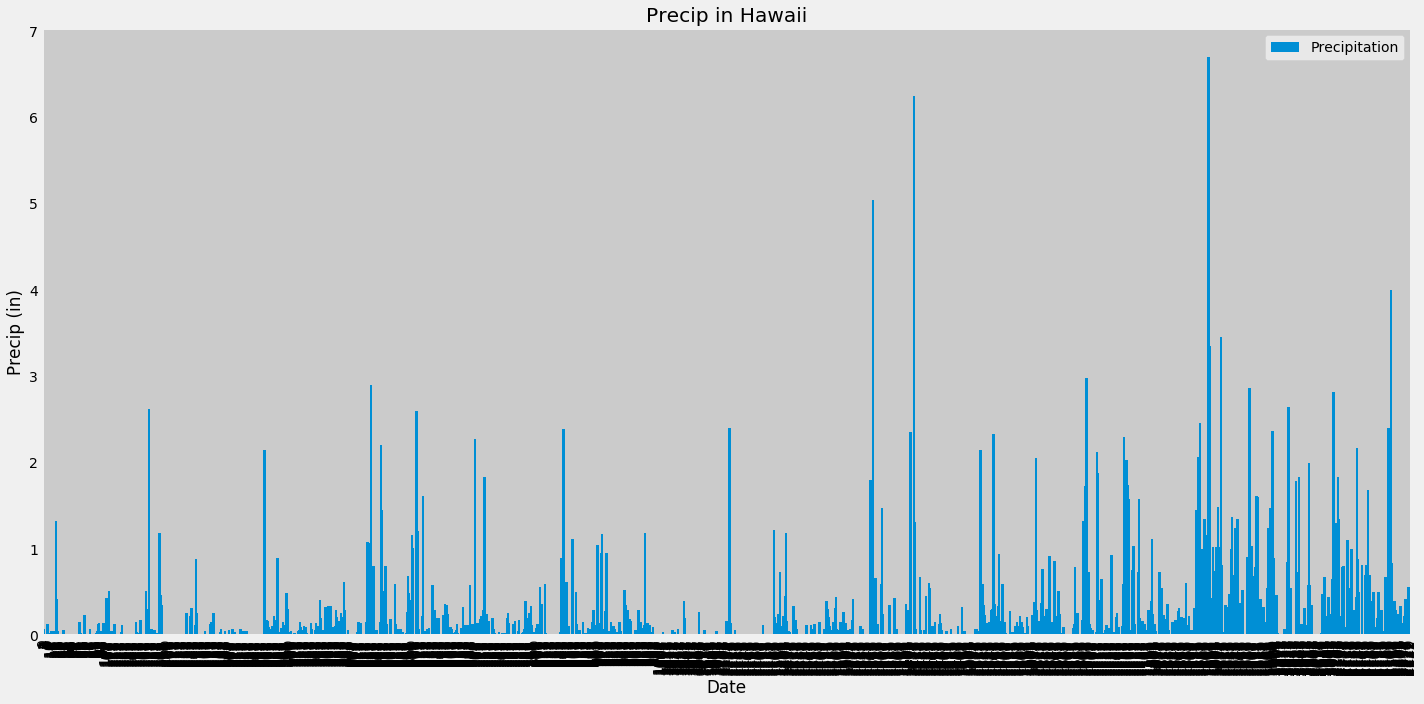

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precip.plot.bar(title = "Precip in Hawaii", figsize =(20, 10), width = 4)
plt.xlabel("Date")
plt.ylabel("Precipitation(in)")

plt.tight_layout()

![precipitation](Images/precipitation.png)

In [21]:
conn = engine.connect()
data = pd.read_sql("SELECT * FROM station", conn)
data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.tobs != 'NaN').all()
station_df = pd.DataFrame(stations, columns=['Station', 'TOBS'])
grouped_st = station_df.groupby(['Station']).count()
grouped_st.sort_values('TOBS', ascending = False)

,TOBS
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

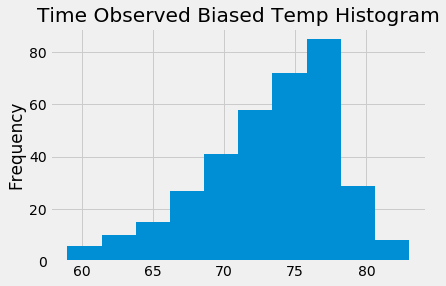

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_high = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == 'USC00519281').filter(Measurement.date > '2016-08-23').all()
year_temp = pd.DataFrame(station_high, columns = ['Station', 'TOBS'])
year_temp.hist('TOBS')
plt.title("Time Observed Biased Temp Histogram")
plt.ylabel('Frequency')

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_nums = calc_temps('2017-04-18', '2017-04-25')
trip_temps = pd.DataFrame(temp_nums, columns = ['Min Temp', 'Avg Temp', 'Max Temp'])
trip_temps

,Min Temp,Avg Temp,Max Temp
0,67.0,74.0,83.0


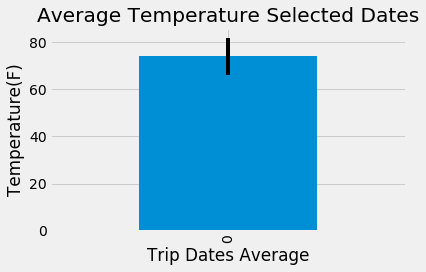

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ptp = trip_temps['Max Temp'] - trip_temps['Min Temp']
trip_temps['Avg Temp'].plot.bar(yerr = ptp/2)
plt.ylabel("Temperature(F)")
plt.xlabel("Trip Dates Average")
plt.title('Average Temperature Selected Dates')
plt.tight_layout()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rain = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).\
filter(Measurement.date > '2017-04-18').filter(Measurement.date<'2017-04-25').filter(Measurement.prcp != 'NaN').filter(Measurement.station == Station.station).group_by(Measurement.station).all()
stations = pd.DataFrame(total_rain, columns = ['ID', 'Precip Total', 'Name', 'Latitude', 'Longitude', 'Elevation'])
stations.sort_values(['Precip Total'], ascending = False )


,ID,Precip Total,Name,Latitude,Longitude,Elevation
2,USC00516128,0.14,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
0,USC00513117,0.02,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519281,0.02,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00519397,0.02,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00514830,0.00,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


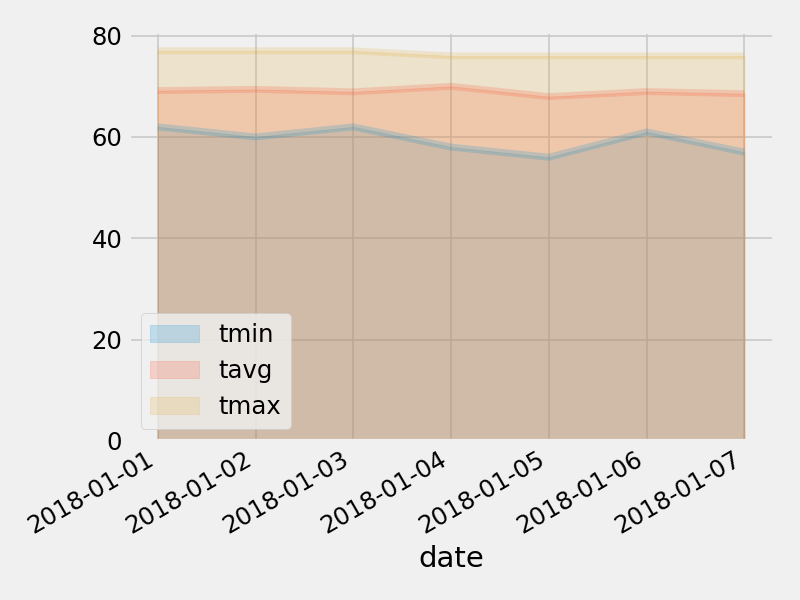

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
